In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf
from scipy.optimize import curve_fit
from typing import List, Union, Iterable, Tuple
from infix import shift_infix as infix
from sklearn.metrics import r2_score
from scipy.signal import hilbert
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

In [24]:
@infix
def fC(f, g):
    return f(g)


In [25]:
pathData: str = '../../../data/realData/Tanouchi/'
dfTanouchi25: pd.DataFrame = pd.read_csv(pathData + 'Tanouchi25C.csv')
dfTanouchi37: pd.DataFrame = pd.read_csv(pathData + 'Tanouchi37C.csv')
dataFrames: List[pd.DataFrame] = [dfTanouchi25, dfTanouchi37]


In [26]:
for df in dataFrames:
    df['lineage_ID'] = df['lineage_ID'].astype(int)


def lineages(df: pd.DataFrame) -> List[np.array]:
    uniqueLineages: np.array = df['lineage_ID'].unique()
    returnList = []
    for lineage in uniqueLineages:
        newDf: pd.DataFrame = df[df['lineage_ID'] == lineage]
        returnList.append(np.array(newDf['length_birth']))

    return returnList


In [27]:
def autoCorrelationFunc(t: Union[float, np.array], n_c: Union[float, np.array], xi: Union[float, np.array]) -> Union[float, np.array]:
    return t**(-n_c) * np.exp(-t/xi)


def autoCorrelationFuncExp(t: Union[float, np.array], a: Union[float, np.array], xi: Union[float, np.array]) -> Union[float, np.array]:
    return a + np.exp(-t/xi)


In [28]:
def getAutocorrelationInfo(timeSeries: Iterable, autoCorrFunc: callable) -> tuple:
    autocorrelation: Iterable = acf(
        timeSeries, fft=True, nlags=len(timeSeries) - 1)
    popt, _ = curve_fit(autoCorrFunc, list << fC >> range(
        1, len(autocorrelation) + 1), autocorrelation)
    r2Score = r2_score(y_true=timeSeries, y_pred=autocorrelation)
    return autocorrelation, popt, r2Score


In [29]:
lineages25 = lineages(dfTanouchi25)
lineages37 = lineages(dfTanouchi37)
autocorrelationInfo25 = (
    list(map(lambda x: getAutocorrelationInfo(x, autoCorrelationFunc), lineages25)))
autocorrelationInfo37 = list(
    map(lambda x: getAutocorrelationInfo(x, autoCorrelationFunc), lineages37))


/Applications/anaconda3/envs/new_base/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


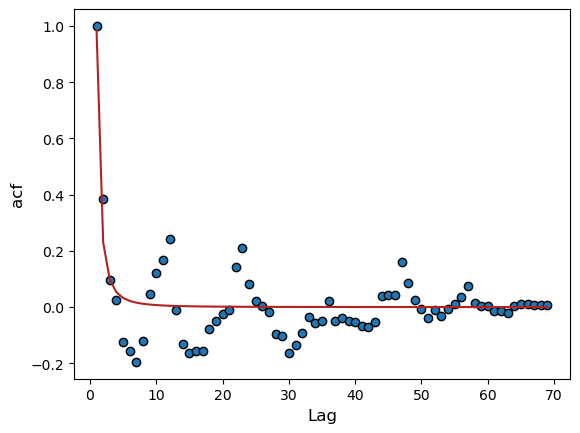

In [30]:
sampleToPlot = autocorrelationInfo25[3]
analytic_signal = hilbert(sampleToPlot[0])
amplitude_envelope = np.abs(analytic_signal)
plt.scatter(range(1, len(sampleToPlot[0]) + 1),
            sampleToPlot[0], edgecolor='black')
plt.plot(range(1, len(sampleToPlot[0]) + 1), autoCorrelationFunc(np.array(
    list(range(1, len(sampleToPlot[0]) + 1))), *sampleToPlot[1]), color='firebrick')
plt.xlabel('Lag', fontsize=12)
plt.ylabel('acf', fontsize=12)
plt.show()


Text(0.5, 0, 'Lineage id')

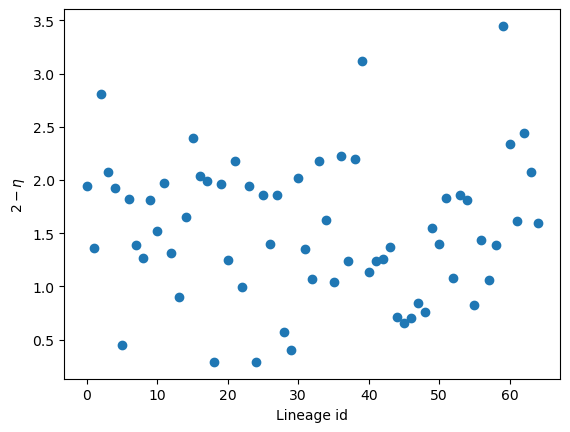

In [31]:
plt.scatter(range(len(list(map(lambda x: x[1][0], autocorrelationInfo25)))), list(
    map(lambda x: x[1][0], autocorrelationInfo25)))
plt.ylabel('$2-\eta$')
plt.xlabel('Lineage id')

Text(0.5, 1.0, 'correlation length $\\xi$, Tanouchi $37^oC$')

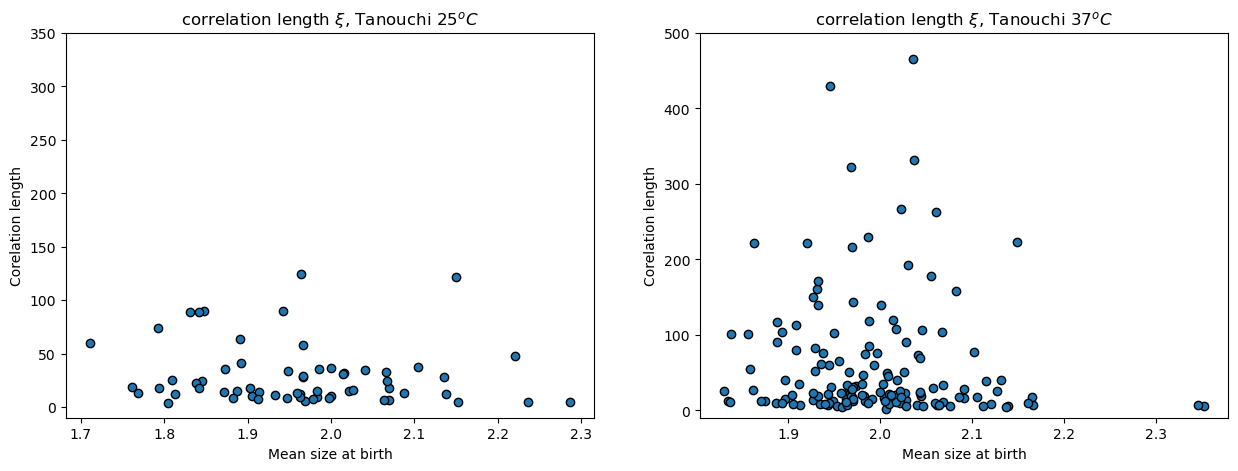

In [32]:
fig, ax_ = plt.subplots(1, 2, figsize=(15, 5))
ax1, ax2 = ax_.flatten()
corLengths25 = list << fC >> map(lambda x: x[1][1], autocorrelationInfo25)
ax1.scatter(list << fC >> map(lambda x: np.mean(x), lineages25),
            corLengths25, edgecolor='black')
ax1.set_xlabel('Mean size at birth')
ax1.set_ylabel('Corelation length')
_ = ax1.set_ylim(bottom=-10, top=350)
corLengths37 = list << fC >> map(lambda x: x[1][1], autocorrelationInfo37)
ax2.scatter(list << fC >> map(lambda x: np.mean(x), lineages37),
            corLengths37, edgecolor='black')
ax2.set_xlabel('Mean size at birth')
ax2.set_ylabel('Corelation length')
_ = ax2.set_ylim(bottom=-10, top=500)
ax1.set_title('correlation length $\\xi$, Tanouchi $25^oC$')
ax2.set_title('correlation length $\\xi$, Tanouchi $37^oC$')


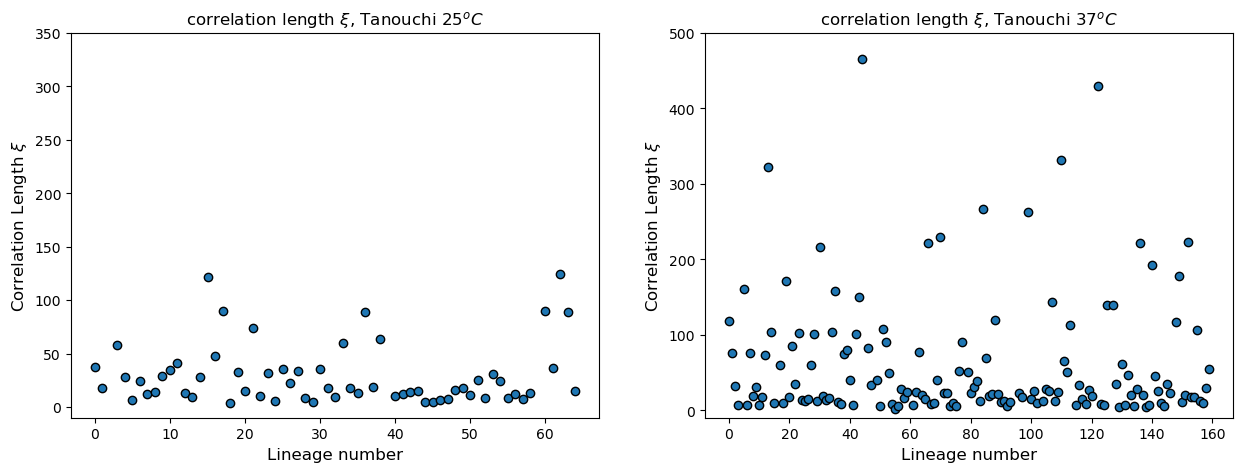

In [33]:
fig, ax_ = plt.subplots(1, 2, figsize=(15, 5))
ax1, ax2 = ax_
corLengths25 = list << fC >> map(lambda x: x[1][1], autocorrelationInfo25)
ax1.scatter(range << fC >> len(corLengths25), corLengths25, edgecolor='black')
ax1.set_title('correlation length $\\xi$, Tanouchi $25^oC$')
ax1.set_xlabel('Lineage number', fontsize=12)
ax1.set_ylabel('Correlation Length $\\xi$', fontsize=12)
_ = ax1.set_ylim(bottom=-10, top=350)

corLengths37 = list << fC >> map(lambda x: x[1][1], autocorrelationInfo37)
ax2.scatter(range << fC >> len(corLengths37), corLengths37, edgecolor='black')
ax2.set_title('correlation length $\\xi$, Tanouchi $37^oC$')
ax2.set_xlabel('Lineage number', fontsize=12)
_ = ax2.set_ylabel('Correlation Length $\\xi$', fontsize=12)
_ = ax2.set_ylim(bottom=-10, top=500)


In [34]:
def cumulative_data(array):
    array = np.array(array)
    array = np.sort(array)
    array = array[~np.isnan(array)]
    array = array[array >= 0]
    cumul = 1 - np.arange(0, len(array))/(len(array))
    return array, cumul


sample25 = lineages25[0]
sample37 = lineages37[0]
sampleFiltered25, sampleCumulative25 = cumulative_data(sample25)
sampleFiltered37, sampleCumulative37 = cumulative_data(sample37)

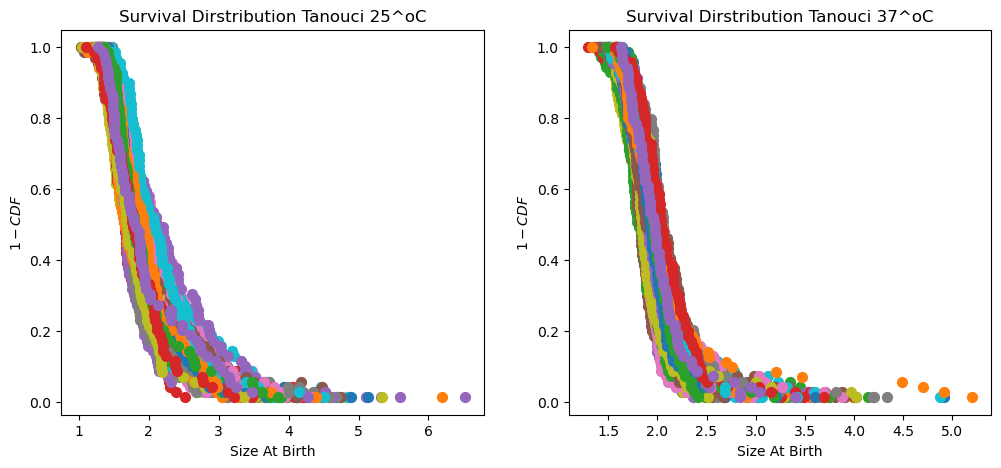

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax1, ax2 = ax.flatten()
for lineage25, lineage37 in zip(lineages25, lineages37):
    sampleFiltered25, sampleCumulative25 = cumulative_data(lineage25)
    sampleFiltered37, sampleCumulative37 = cumulative_data(lineage37)
    ax1.scatter(sampleFiltered25, sampleCumulative25, s=50)
    ax2.scatter(sampleFiltered37, sampleCumulative37, s=50)
    for ax_, temp in zip(ax.flatten(), ['25', '37']):
        # ax_.set_yscale('log')
        # ax_.set_xscale('log')
        ax_.set_xlabel('Size At Birth')
        ax_.set_ylabel('$1 - CDF$')
        ax_.set_title(f'Survival Dirstribution Tanouci {temp}^oC')